**Dataset - Kaggle**

In [8]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os


train_dir = '/content/drive/MyDrive/opsw/dataset/train'  # change links to yours
test_dir = '/content/drive/MyDrive/opsw/dataset/test'

# data preprocessing (ResNet50's input size : resizing dataset into 224x224)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet50의 표준값
])


train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Resnet 50**

In [ ]:
!pip install torch torchvision torchaudio matplotlib pandas scikit-learn


In [11]:
import torch.nn as nn
import torch.optim as optim

# Pre-trained ResNet50 모델 불러오기
model = torchvision.models.resnet50(pretrained=True)

# 마지막 Fully Connected 레이어 수정 (2개의 클래스로 분류: Chihuahua vs Muffin)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2개의 클래스 (치와와, 머핀)

# 모델을 GPU로 옮기기 (가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수 및 최적화 함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Model learning**

before learning, find best parameters - hyper parameter tuning

In [7]:
# parameter tuning process

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn


learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64]
optimizers = ['adam', 'sgd']

# preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/opsw/dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/opsw/dataset/test', transform=transform)

# hyperparameter tuning here
best_acc = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"Running experiment with lr={lr}, batch_size={batch_size}, optimizer={opt}")

            # DataLoader
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

            # initialize model
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, 2)
            model = model.to(device)

            # set optimizer
            if opt == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)

            # loss function
            criterion = nn.CrossEntropyLoss()

            # model learning
            for epoch in range(10):
                model.train()
                running_loss = 0.0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                # test accuracy evaluation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                print(f"Epoch {epoch+1}/10, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

                # save model
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_params = {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': opt}
                    torch.save(model.state_dict(), 'best_model.pth')
                    print(f"New best accuracy: {best_acc:.2f}%")

print("Best hyperparameters:", best_params)


Running experiment with lr=0.1, batch_size=16, optimizer=adam
Epoch 1/10, Loss: 1.0582, Accuracy: 21.39%
New best accuracy: 21.39%
Epoch 2/10, Loss: 55.0506, Accuracy: 66.95%
New best accuracy: 66.95%
Epoch 3/10, Loss: 5.0993, Accuracy: 22.24%
Epoch 4/10, Loss: 1.2741, Accuracy: 22.24%
Epoch 5/10, Loss: 1.5202, Accuracy: 22.24%
Epoch 6/10, Loss: 0.5732, Accuracy: 22.24%
Epoch 7/10, Loss: 0.4487, Accuracy: 22.24%
Epoch 8/10, Loss: 0.4188, Accuracy: 22.24%
Epoch 9/10, Loss: 0.2217, Accuracy: 22.24%
Epoch 10/10, Loss: 0.1847, Accuracy: 22.24%
Running experiment with lr=0.1, batch_size=16, optimizer=sgd
Epoch 1/10, Loss: 0.5126, Accuracy: 22.24%
Epoch 2/10, Loss: 1.1723, Accuracy: 76.79%
New best accuracy: 76.79%
Epoch 3/10, Loss: 0.0003, Accuracy: 92.71%
New best accuracy: 92.71%
Epoch 4/10, Loss: 0.0122, Accuracy: 93.56%
New best accuracy: 93.56%
Epoch 5/10, Loss: 0.1357, Accuracy: 79.22%
Epoch 6/10, Loss: 3.6205, Accuracy: 77.76%
Epoch 7/10, Loss: 0.4788, Accuracy: 77.04%
Epoch 8/10, Lo

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")


        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Best model saved with accuracy: {best_acc:.2f}%")

    print(f"Training complete. Best accuracy: {best_acc:.2f}%")


In [13]:
# model learning
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Loss: 0.0981
Validation Accuracy: 97.64%
Best model saved with accuracy: 97.64%
Epoch [2/10], Loss: 0.0218
Validation Accuracy: 98.06%
Best model saved with accuracy: 98.06%
Epoch [3/10], Loss: 0.0133
Validation Accuracy: 97.89%
Epoch [4/10], Loss: 0.0089
Validation Accuracy: 98.23%
Best model saved with accuracy: 98.23%
Epoch [5/10], Loss: 0.0067
Validation Accuracy: 98.23%
Epoch [6/10], Loss: 0.0050
Validation Accuracy: 98.23%
Epoch [7/10], Loss: 0.0043
Validation Accuracy: 98.23%
Epoch [8/10], Loss: 0.0038
Validation Accuracy: 98.40%
Best model saved with accuracy: 98.40%
Epoch [9/10], Loss: 0.0028
Validation Accuracy: 98.23%
Epoch [10/10], Loss: 0.0018
Validation Accuracy: 98.23%
Training complete. Best accuracy: 98.40%


**evaluate model**

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [15]:
# test dataset
test_dir = '/content/drive/MyDrive/opsw/dataset/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# model evaluation
evaluate_model(model, test_loader)


Test Accuracy: 98.23%


**visualization**

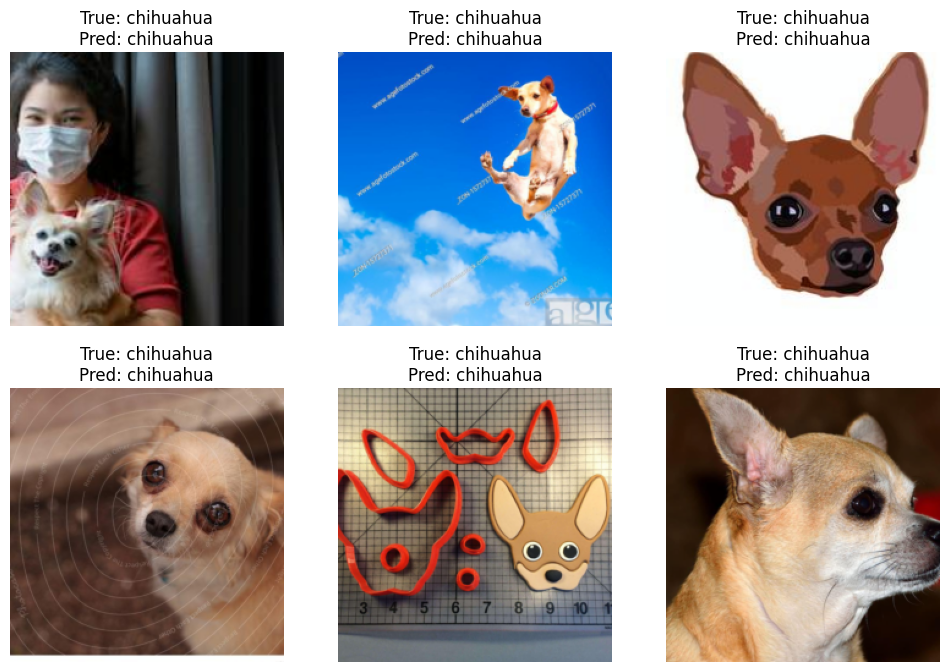

In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader


def visualize_predictions(model, test_loader, num_images=6):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(12, 8))
    for i in range(num_images):
        ax = fig.add_subplot(2, 3, i+1)

        img = images[i].cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

        ax.imshow(img)

        true_label = test_loader.dataset.classes[labels[i].item()]
        predicted_label = test_loader.dataset.classes[preds[i].item()]
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis('off')

    plt.show()

# visualization
visualize_predictions(model, test_loader, num_images=6)  # 6개의 이미지를 시각화
